In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.testing as npt
import fl_funcs_proj

## Beginning some pre-processing using original functions, to set up for the shear, model fitting, etc. analysis

In [54]:
# Initial information about the flare we're interested in

year = 2013
mo = 10
day = 13
sthr = 0
stmin = 12
arnum = 11865
xclnum = 1.7
xcl = 'M'
flnum = 1401

In [55]:
bestflarefile = "/Users/owner/Desktop/CU_Research/MAT_SOURCE/bestperf_more.mat"

In [56]:
# Load data
sav_data_aia, sav_data, best304, start304, peak304, end304, eventindices,\
    times304, curves304, aia_cumul8, aia_step8, last_cumul8, hmi_dat,\
    last_mask = fl_funcs_proj.load_variables(bestflarefile, year, mo, day,
                                             sthr, stmin, arnum, xclnum, xcl)

In [10]:
# Establish some important parameters
X, Y, conv_f, xarr_Mm, yarr_Mm = fl_funcs_proj.conv_facts()


In [11]:
# Masking of SDO HMI images in each polarity
hmi_cumul_mask1, hmi_step_mask1, hmi_pos_mask_c, hmi_neg_mask_c \
    = fl_funcs_proj.pos_neg_masking(aia_cumul8, aia_step8, hmi_dat, last_mask)

In [12]:
# Isolation of ribbons; removal of spurs not important to ribbon geometry
neg_rem, pos_rem = fl_funcs_proj.spur_removal_sep(hmi_neg_mask_c,
                                                  hmi_pos_mask_c, pos_crit=3,
                                                  neg_crit=2)

In [13]:
# Convolution with Gaussian
hmi_con_pos_c, hmi_con_neg_c, pil_mask_c = fl_funcs_proj.gauss_conv(pos_rem,
                                                                    neg_rem)

In [14]:
# Identification of polarity inversion line
pil_mask_c, ivs, dvs, hmik = fl_funcs_proj.pil_gen(pil_mask_c, hmi_dat)

In [15]:
# Determine values for ribbon separation from PIL
aia8_pos, aia8_neg = fl_funcs_proj.mask_sep(aia_step8, hmi_dat)

distpos_med, distpos_mean, distneg_med, distpos_mean \
    = fl_funcs_proj.separation(aia_step8, ivs, dvs, aia8_pos, aia8_neg)

In [16]:
# Determine values for ribbon elongation along PIL

aia8_pos_2, aia8_neg_2 = fl_funcs_proj.mask_elon(aia_cumul8, hmi_dat)
neg_rem1, pos_rem1 = fl_funcs_proj.spur_removal_elon(aia8_pos_2, aia8_neg_2)
ivs_lim, dvs_lim, med_x, med_y = fl_funcs_proj.lim_pil(ivs, dvs)

 Below I'll give an example of the ribbons we are looking at.  Note that the positive polarity is where energy deposition occurs at the positive edge of magnetic field lines; likewise for negative polarity (top and bottom, respectively).  The Polarity Inversion Line (PIL) is also shown.

(250.0, 550.0)

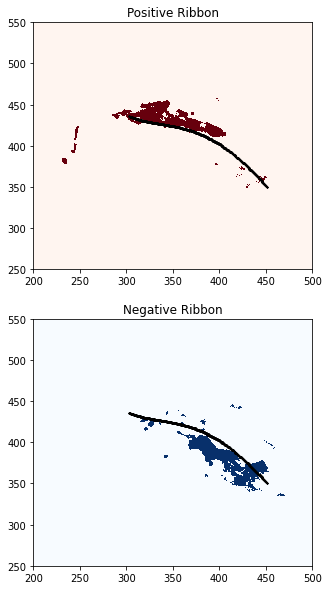

In [77]:
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(5,10))
ax1.pcolormesh(neg_rem1[-1,:,:],cmap='Reds')
ax1.scatter(ivs_lim,dvs_lim,c='k',s=.5)
ax1.set_xlim([200,500])
ax1.set_ylim([250,550])
ax1.set_title('Positive Ribbon')
ax2.pcolormesh(pos_rem1[-1,:,:],cmap='Blues')
ax2.scatter(ivs_lim,dvs_lim,c='k',s=.5)
ax2.set_title('Negative Ribbon')
ax2.set_xlim([200,500])
ax2.set_ylim([250,550])

There is a bit of crossover in the negative ribbon, but for the most part this looks good, and should be just fine in identifying the motion of ribbons along the inversion line.  What I show here is the last cumulative image in the series - in the time steps before this, the ribbons develop into their final form (shown here).

Now we will determine how the ribbon moves along this PIL, in both the perpendicular and parallel components.  We call these "separation" and "elongation" respectively, in reference to their motion along the polarity inversion line (shown in black in the figures above).

In [17]:
ylim0_neg = 400
ylim1_neg = int(round(med_y)+100)
ylim0_pos = int(round(med_y)-100)
ylim1_pos = int(round(med_y)+100)
xlim0_neg = 300
xlim1_neg = 400
xlim0_pos = 350
xlim1_pos = int(round(med_y)+100)

In [57]:
# This next function removes pixels which will get in the way of elongation determination
aia_pos_rem, aia_neg_rem = fl_funcs_proj.rib_lim_elon(aia8_pos_2, aia8_neg_2,
                                                      pos_rem1, neg_rem1,
                                                      med_x, med_y, ylim0_pos,
                                                      ylim1_pos, ylim0_neg,
                                                      ylim1_neg, xlim0_pos,
                                                      xlim1_pos, xlim0_neg,
                                                      xlim1_neg)

In [19]:
# Left and right coordinates
lr_coord_neg, lr_coord_pos = fl_funcs_proj.find_rib_coordinates(aia_pos_rem,
                                                                aia_neg_rem)

In [20]:
# Sorting the PIL
ivs_sort, dvs_sort, sortedpil = fl_funcs_proj.sort_pil(ivs_lim, dvs_lim)

In [21]:
# Finding the coordinates of PIL near the extremes of the ribbons
pil_right_near_pos, pil_left_near_pos, pil_right_near_neg, pil_left_near_neg \
    = fl_funcs_proj.elon_dist_arrays(lr_coord_pos, lr_coord_neg, ivs_lim,
                                     dvs_lim, ivs_sort, dvs_sort)

In [22]:
# Elongation values
lens_pos, lens_neg = fl_funcs_proj.elongation(pil_right_near_pos,
                                              pil_left_near_pos,
                                              pil_right_near_neg,
                                              pil_left_near_neg,
                                              sortedpil)

In [23]:
# Rename separation values to something more generic

dist_pos = distpos_med
dist_neg = distneg_med

In [24]:
# Converting separation and elongation to Mm

lens_pos_Mm, lens_neg_Mm, distpos_Mm, distneg_Mm, dneg_len, dpos_len, \
    dneg_dist, dpos_dist = fl_funcs_proj.convert_to_Mm(lens_pos, dist_pos,
                                                       lens_neg, dist_neg,
                                                       conv_f)

In [25]:
# Loading parameters for 304 and 1600 Angstrom light curves
startin, peakin, endin, times, s304, e304, filter_304, med304, std304, \
    timelab, aiadat, nt, dn1600, time304, times1600 \
    = fl_funcs_proj.prep_304_1600_parameters(sav_data_aia, sav_data,
                                             eventindices, flnum, start304,
                                             peak304, end304, times304,
                                             curves304)

posrib, negrib, pos1600, neg1600 = fl_funcs_proj.img_mask(aia8_pos, aia8_neg,
                                                          aiadat, nt)

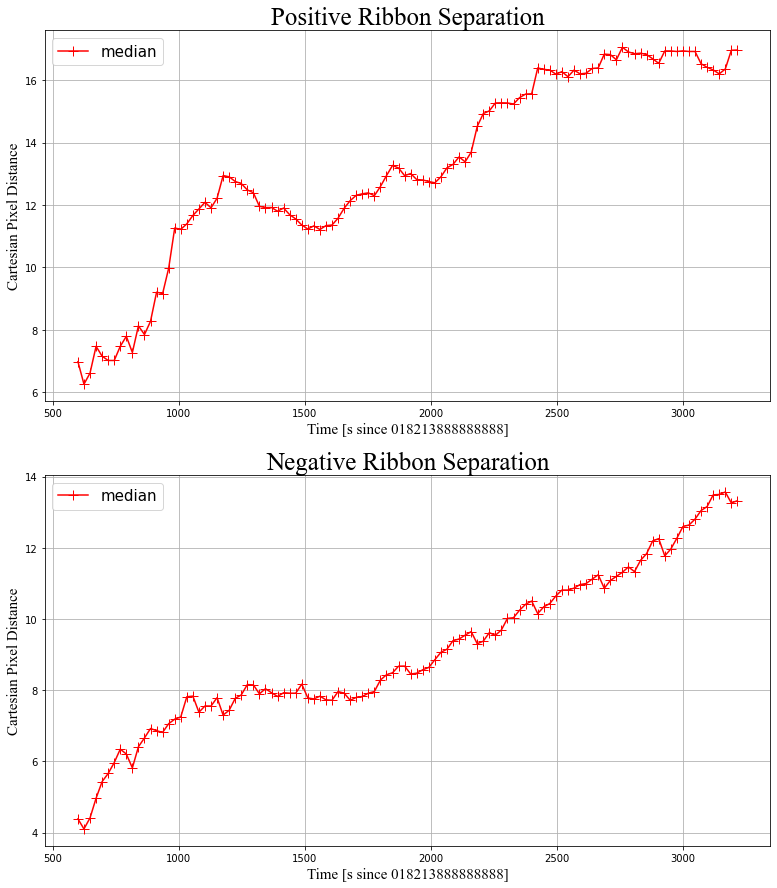

In [26]:
# Plotting ribbon separation

pltstrt = 25
fl_funcs_proj.ribbon_sep_plot(dist_pos, dist_neg, times, flnum, pltstrt)

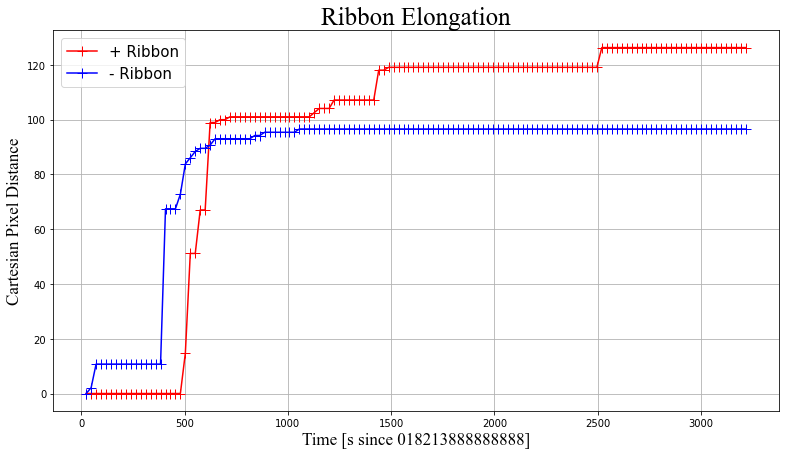

In [27]:
# Plotting ribbon elongation

pltstrt = 1
fl_funcs_proj.ribbon_elon_plot(lens_pos, lens_neg, times, pltstrt, flnum)

The next step is to process the SDO/AIA 1600 Angstrom images to find the cumulative area of the ribbons.  See the functions themselves in the GitHub repo for specifics, but basically the idea is to determine the reconnection flux and the ribbon areas for each time step - later, we will test to see if these fit an exponential model

In [78]:
# Processing data for reconnection flux model
dt1600, dt304 = fl_funcs_proj.prep_times(dn1600, time304)
posrib, negrib, pos1600, neg1600 = fl_funcs_proj.img_mask(aia8_pos, aia8_neg,
                                                          aiadat, nt)
hmi, aia8_pos, aia8_neg, aia8_inst_pos, aia8_inst_neg, peak_pos, \
    peak_neg = fl_funcs_proj.flux_rec_mod_process(
        sav_data, dt1600, pos1600, neg1600)

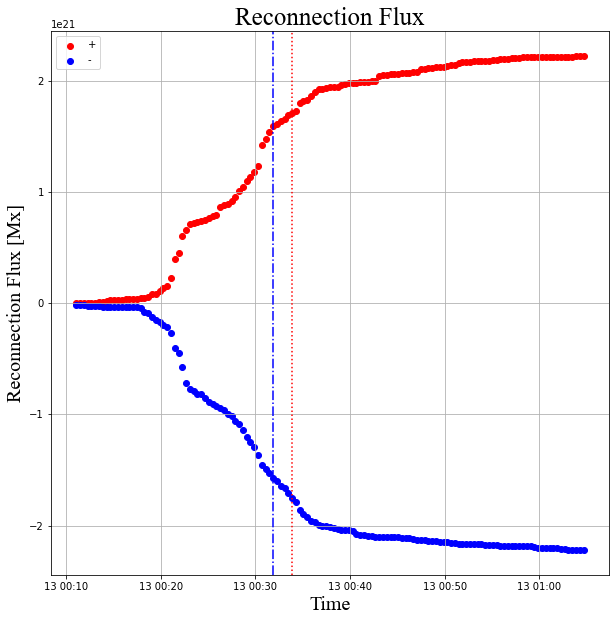

In [31]:
# Load fluxes and pixel counts
rec_flux_pos, rec_flux_neg, pos_pix, neg_pix, pos_area_pix, neg_area_pix, ds2,\
    pos_area, neg_area = fl_funcs_proj.cumul_flux_process(aia8_pos, aia8_neg,
                                                          conv_f, flnum,
                                                          peak_pos, peak_neg,
                                                          hmi, dt1600)

I'm going to do a quick exponential model fit to the ribbon area to get some good "guesses" for the parameters required for input into the gv.gvar model fitting which I do at the end.

We want to isolate the impulsive phase of the ribbon motion.  I do this simply by knowledge of the light curve and the physics behind particle acceleration (release of hard X-rays correlates roughly with the particle acceleration phase of the flare, which is much more impulsive and drives the atmospheric heating that leads to more thermal soft X-ray emmission, which is longer-lasting and occurs higher in the atmosphere in addition to the photospheric footpoints).  
This flare is somewhat unusual in that it has two "bursts" of this impulsive energy release, so I'll isolate the first of these.  The impulsive phase ends around index 29 for this flare, so I isolate this region.

In [35]:
# Exponential model fitting
exp_ind = 29
poptposflx, pcovposflx, poptnegflx, pcovnegflx, \
    poptpos, poptneg, pcovpos, pcovneg, rise_pos_flx, \
    rise_neg_flx = fl_funcs_proj.exp_curve_fit(exp_ind, exp_ind,
                                               rec_flux_pos, rec_flux_neg,
                                               fl_funcs_proj.exponential, fl_funcs_proj.exponential_neg,
                                               pos_area, neg_area)

/Users/owner/Desktop/CU_Spring_2022/Computational_Physics/phys-5070-final-project-tamburri/fl_funcs_proj.py:678: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x)
/Users/owner/Desktop/CU_Spring_2022/Computational_Physics/phys-5070-final-project-tamburri/fl_funcs_proj.py:700: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(b * x)


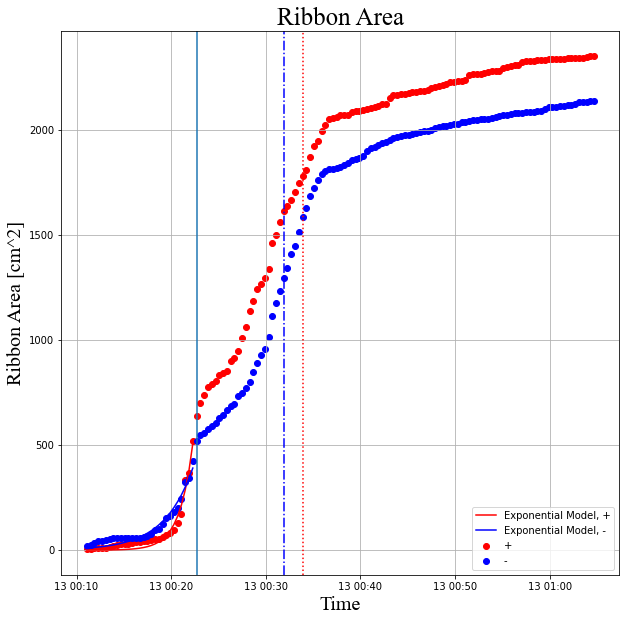

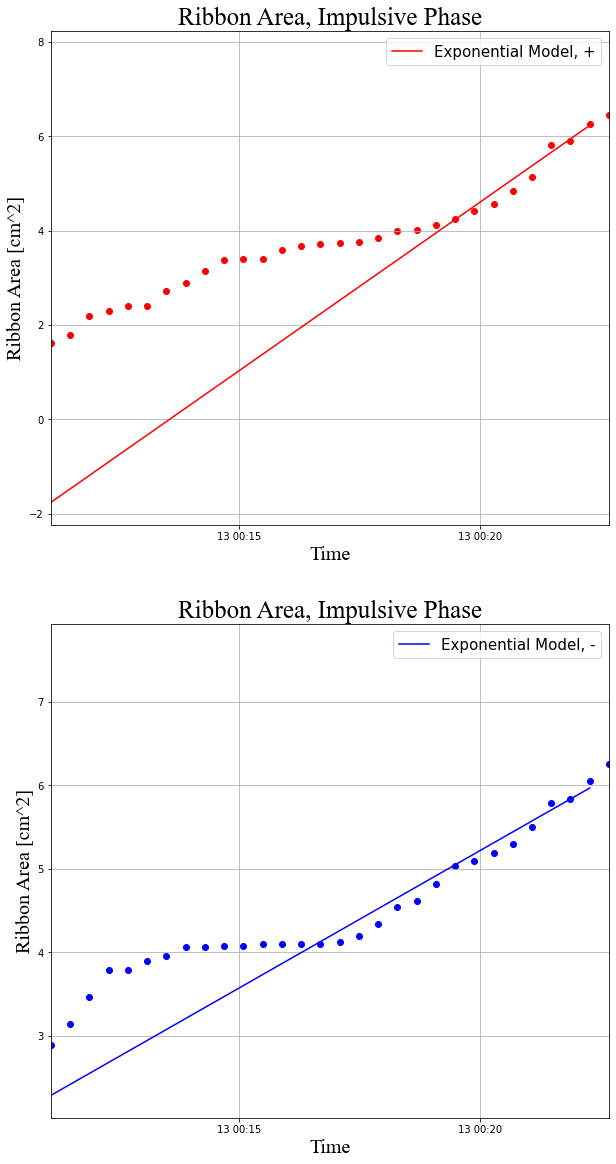

In [36]:
# Plot ribbon areas
fl_funcs_proj.rib_area_plt(dt1600, poptpos, poptneg, flnum, pos_area_pix,
                           neg_area_pix, peak_pos, peak_neg, exp_ind)

Hmm... it looks like the result of the fitting is not too great early on in this window.  This is probably because the actual flare doesn't start until later on, so we are actually fitting a few points to the non-flare quiet time! We will correct for this later on, but at least now we have good estimates for the cofficients (parameters) that an exponential model will take on for the ribbon area exponential models.

## Now we have all of the functions which are necessary to have the appropriate variables for the rest of the analysis.  Now onto some shear and model fit testing:

The magnetic shear is defined as the component of the magnetic field which is along the polarity inversion line (PIL).  To quantify this, we will take the ratio of this component to the perpendicular component of the magnetic field to the PIL.  But we don't have actual images of the magnetic loops - that would be more in the 171 Angstrom bandpass, which is also in the SDO database but not used here.  So we use the footpoints of the ribbons, by definition the energy deposition spots of the magnetic field lines, as a proxy for magnetic loop orientation.  Theoretically, the positive and negative ribbons represent the positive and negative ends of each magnetic loop, so the relative orientation of these pixels should show us exactly how the magnetic loops are oriented, assuming a simple loop structure "straddling" the PIL.

In [38]:
# Establish limits for ribbons corresponding to shear code.
negylow = 400
negyhi = int(round(med_y) + 100)
negxlow = 300
negxhi = 400

posylow = int(round(med_y) - 100)
posyhi = int(round(med_y) + 100)
posxlow = 350
posxhi = int(round(med_y) + 100)

In [39]:
# Isolate ribbons appropriately for shear analysis
aia_neg_rem_shear, aia_pos_rem_shear = fl_funcs_proj.\
    shear_ribbon_isolation(aia8_neg, aia8_pos, med_x, med_y, negylow=negylow,
                           negyhi=negyhi, posylow=posylow, posyhi=posyhi,
                           negxlow=negxlow, negxhi=negxhi, posxlow=posxlow,
                           posxhi=posxhi)

In [40]:
# Left and right coordinates of positive and negative ribbons
lr_coord_neg_shear, lr_coord_pos_shear = \
    fl_funcs_proj.leftrightshear(aia_pos_rem_shear, aia_neg_rem_shear)

In [41]:
# PIL pixels closest to the left and right coordinates of positive and negative
# ribbons
pil_right_near_pos_shear, pil_left_near_pos_shear, pil_right_near_neg_shear,\
    pil_left_near_neg_shear = fl_funcs_proj.sheardists(lr_coord_pos_shear,
                                                       lr_coord_neg_shear,
                                                       ivs_sort, dvs_sort)

In [42]:
# Guide field to the right and left edges of ribbons
guide_right, guide_left = fl_funcs_proj.guidefieldlen(pil_right_near_pos_shear,
                                                      pil_left_near_pos_shear,
                                                      pil_right_near_neg_shear,
                                                      pil_left_near_neg_shear,
                                                      sortedpil)

In [43]:
# Guide field ratio to the right and left edges of ribbons
left_gfr, right_gfr = fl_funcs_proj.gfrcalc(guide_left, guide_right,
                                            distneg_med, distpos_med)


/Users/owner/Desktop/CU_Spring_2022/Computational_Physics/phys-5070-final-project-tamburri/fl_funcs_proj.py:417: RuntimeWarning: invalid value encountered in true_divide
  left_gfr = guide_left/(distneg_med+distpos_med)
/Users/owner/Desktop/CU_Spring_2022/Computational_Physics/phys-5070-final-project-tamburri/fl_funcs_proj.py:418: RuntimeWarning: invalid value encountered in true_divide
  right_gfr = guide_right/(distneg_med+distneg_med)


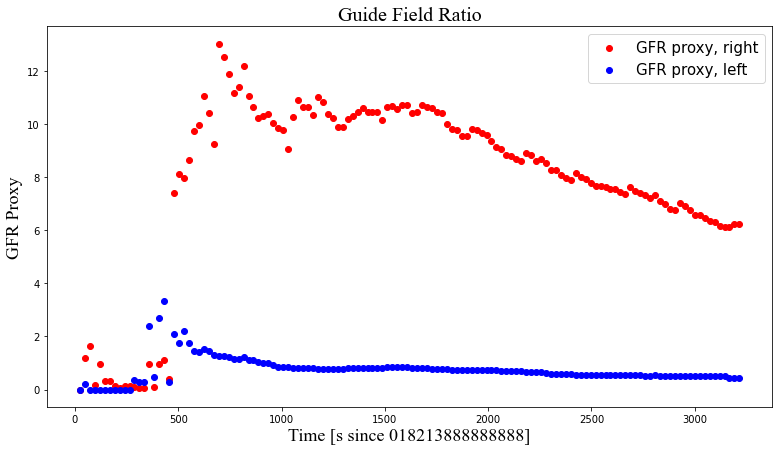

In [44]:
# Plot guide field ratio
fl_funcs_proj.plt_gfr(times, right_gfr, left_gfr, flnum)

The initial part of this plot shows, apparently, a small value for shear at both edges of the ribbons.  This is not real - there are too few points for these time steps, so it should be treated as a transient period.  The maximum in each of these representations of shear should be taken to be the end of the transient period.  We can see that the guide field ratio lessens as the flare progresses, which is exactly what the theory suggests we should see!

Remember the ribbon areas I mentioned earlier? Let's do some proper model fitting for that.  First, I need to establish the timesteps for model fitting, removing the pre-flare quiet Sun.  Then we have another issue - no assigned error measurements.  For now I will assume that there is a simple probability that the instrument correctly identified a ribbon pixel (x, in the below examples) and use that as the error estimate for our least squares fitting.  I'll change x to show how different measurements for the error change 

In [45]:
# Limit of timesteps for model fitting
modstrt = 16
modend = 29

In [46]:
# Initial fraction of incorrectly-identified pixels
x = 0.1

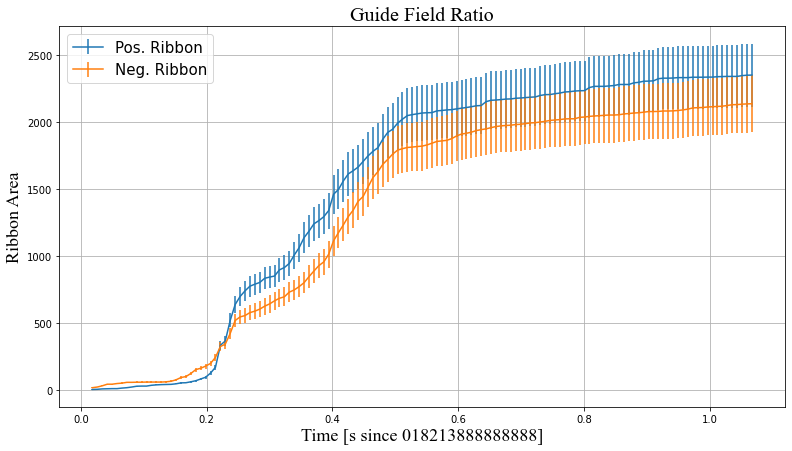

In [48]:
# Perform error analysis of model fitting
pos_unc, neg_unc = fl_funcs_proj.errorset(aia8_pos, aia8_neg, x)
pos_gvar, neg_gvar = fl_funcs_proj.pltgvarex(pos_area, neg_area, pos_unc,
                                             neg_unc, times, flnum)
fitpos, fitneg = fl_funcs_proj.lsqarea(modstrt, modend, fl_funcs_proj.exp_for_lsqfit,
                                       pos_gvar, neg_gvar, times, poptpos,
                                       poptneg)

In [79]:
print(fitpos)
print(fitneg)


Least Square Fit (no prior):
  chi2/dof [dof] = 6 [11]    Q = 6.5e-10    

Parameters:
              0    30.2 (1.9)     [ 0.171817 +- inf ]  
              1   0.1994 (94)     [ 0.285339 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 17/0.2)
  fitter = scipy_least_squares    method = trf

Least Square Fit (no prior):
  chi2/dof [dof] = 0.34 [11]    Q = 0.98    

Parameters:
              0    66.4 (3.5)     [ 9.83519 +- inf ]  
              1   0.1497 (75)     [ 0.13145 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 18/0.0)
  fitter = scipy_least_squares    method = trf



The fit is not very good, possibly because the error is very low.  If we increase the probability that the pixels are incorrectly identified, the model fits much better:

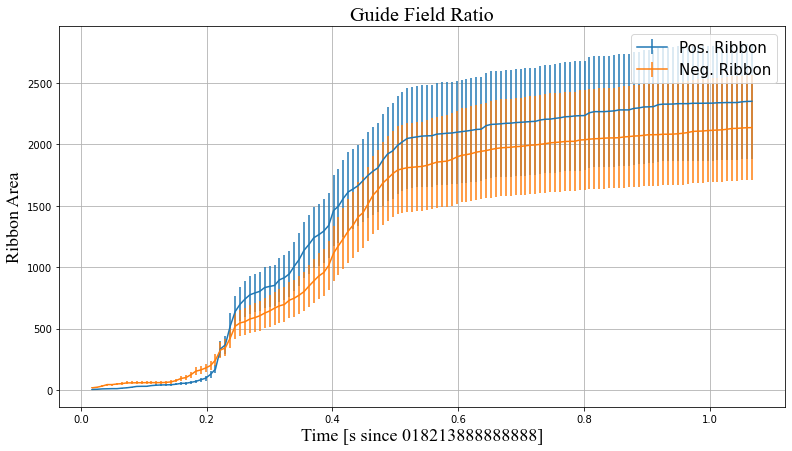

In [51]:
# Second fraction of incorrectly-identified pixels.
x2 = 0.2
pos_unc2, neg_unc2 = fl_funcs_proj.errorset(aia8_pos, aia8_neg, x2)
pos_gvar2, neg_gvar2 = fl_funcs_proj.pltgvarex(pos_area, neg_area, pos_unc2,
                                               neg_unc2, times, flnum)
fitpos2, fitneg2 = fl_funcs_proj.lsqarea(modstrt, modend, fl_funcs_proj.exp_for_lsqfit,
                                         pos_gvar2, neg_gvar2, times, poptpos,
                                         poptneg)

In [80]:
print(fitpos2)
print(fitneg2)
print('A bit better.  So, we need a more appropriate guess for error.')

Least Square Fit (no prior):
  chi2/dof [dof] = 1.5 [11]    Q = 0.12    

Parameters:
              0   30.2 (3.8)     [ 0.171817 +- inf ]  
              1   0.199 (19)     [ 0.285339 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 17/0.0)
  fitter = scipy_least_squares    method = trf

Least Square Fit (no prior):
  chi2/dof [dof] = 0.086 [11]    Q = 1    

Parameters:
              0   66.4 (7.0)     [ 9.83519 +- inf ]  
              1   0.150 (15)     [ 0.13145 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 18/0.0)
  fitter = scipy_least_squares    method = trf

A bit better.  So, we need a more appropriate guess for error.


This is a bit better.  So, we need a more appropriate guess for error.